In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import KFold
import pingouin as pg
import seaborn as sns

In [2]:

def calculate_dew_point(specific_humidity, pressure):
    """Calculate dew point temperature from specific humidity, temperature, and pressure."""
    mixing_ratio = specific_humidity / (1 - specific_humidity)
    vapor_pressure = (mixing_ratio * pressure) / (0.622 + mixing_ratio)
    dew_point = (243.5 * np.log(vapor_pressure / 6.112)) / (17.67 - np.log(vapor_pressure / 6.112))
    return dew_point

def calculate_haines_index(T500, T700, sh700):
    """Calculate the Haines Index given temperatures and specific humidity."""
    # Calculate dew point at 700 hPa
    Td700 = calculate_dew_point(sh700, T700)
    
    #Stability term (700 - 500)
    S = T700 - T500
    if S <= 18:
        stability_points = 1
    elif 18 < S <= 22:
        stability_points = 2
    else:
        stability_points = 3

    # Moisture term (T700 - Td700)
    M = T700 - Td700
    if M < 15:
        moisture_points = 1
    elif 15 <= M <= 21:
        moisture_points = 2
    else:
        moisture_points = 3

    haines_index = stability_points + moisture_points
    return haines_index

In [38]:
# data = pd.read_csv('~/Desktop/columbia/capstone/fire-regimes/data/positives-with-meta.csv').drop(columns=['id1','id2','time','x','y'])

# df_dedup = data.groupby(['source_file','level'], as_index=False).mean()
# df_pivoted = df_dedup.set_index(['source_file', 'level']).unstack('level')
# df_pivoted.columns = [f'{level}-{var}' for var, level in df_pivoted.columns]

data = pd.read_csv('~/Desktop/columbia/capstone/fire-regimes/data/posneg.csv')
Y = data.apply(
    lambda row: calculate_haines_index(
        row['500.0-air'],
        row['700.0-air'],
        row['700.0-shum']
    ),
    axis=1
).to_numpy()

data = data[~np.isnan(data).any(axis=1)].drop(columns=['fire'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

X = data[~(np.abs(scaled_data) > 10).any(axis=1)]
X = scaler.fit_transform(X)

### Load in data for torch

### An AutoEncoder Class with dynamic latent dimension

In [40]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, layers):
        super(AutoEncoder, self).__init__()
        
        #Encoder
        encoder_layers = []
        input_size = 174
        for layer_size in layers:
            encoder_layers.append(torch.nn.Linear(input_size, layer_size))
            encoder_layers.append(torch.nn.ReLU())
            input_size = layer_size
        self.encoder = torch.nn.Sequential(*encoder_layers)
        
        #Decoder
        decoder_layers = []
        reversed_layers = layers[::-1]
        for layer_size in reversed_layers[1:]:
            decoder_layers.append(torch.nn.Linear(input_size, layer_size))
            decoder_layers.append(torch.nn.ReLU())
            input_size = layer_size
        decoder_layers.append(torch.nn.Linear(input_size, 174))
        self.decoder = torch.nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [41]:
def train_model(model,train_loader,n_epochs,optimizer,loss_function):

  losses = []

  for _ in range(n_epochs):
    for profile in train_loader:
        
      # Output of Autoencoder
      reconstructed = model(profile)
        
      # Calculating the loss function
      loss = loss_function(reconstructed, profile)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
      losses.append(loss.item())
  
  return (model,losses)

In [42]:
def rolling_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_loss(losses,window_size):
    loss_floats = [loss for loss in losses]
    smoothed_losses = rolling_average(loss_floats, window_size)
    plt.plot(smoothed_losses)
    plt.show()

In [43]:
train_data = torch.from_numpy(X).float()
haines = torch.from_numpy(Y).float()
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=64, shuffle=True)

In [15]:
latent_dims = [4,6,8,12,16,24,32,48]
results = []

for i,latent_dim in enumerate(latent_dims):
    fold_losses = []
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kf.split(train_data):
        # Split data
        train_subset = torch.utils.data.Subset(train_data, train_idx)
        val_subset = torch.utils.data.Subset(train_data, val_idx)
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)

        # Initialize model, optimizer, and loss function for this fold
        model = AutoEncoder(latent_dim=latent_dim)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-8)
        loss_function = torch.nn.MSELoss()

        # Train model and get average training loss for the fold
        avg_train_loss = train_model(model, train_loader=train_loader, n_epochs=2, optimizer=optimizer, loss_function=loss_function)

        model.eval()
        val_losses = []
        with torch.no_grad():
            for profile in val_loader:
                reconstructed = model(profile)
                val_loss = loss_function(reconstructed, profile)
                val_losses.append(val_loss.item())

        avg_val_loss = np.mean(val_losses)
        fold_losses.append(avg_val_loss)

    # Record average validation loss for this latent dimension
    results.append(np.mean(fold_losses))
    print(f"Latent Dim: {latent_dim}, Avg Validation Loss: {results[i]}")

Latent Dim: 4, Avg Validation Loss: 6.233581316412536e-07
Latent Dim: 6, Avg Validation Loss: 5.260538010285384e-07
Latent Dim: 8, Avg Validation Loss: 4.7482631847733987e-07
Latent Dim: 12, Avg Validation Loss: 6.272702753668034e-07
Latent Dim: 16, Avg Validation Loss: 6.781426023215171e-07
Latent Dim: 24, Avg Validation Loss: 5.517599806729095e-07
Latent Dim: 32, Avg Validation Loss: 4.95390734594458e-07
Latent Dim: 48, Avg Validation Loss: 5.867710998081921e-07


In [57]:
model = AutoEncoder(layers=[128,64,16,2])
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.01,
                             weight_decay = 1e-9)

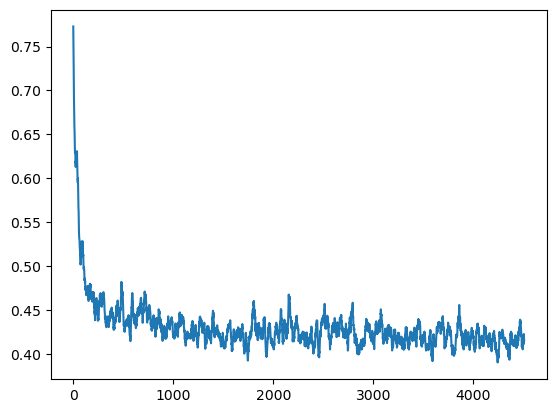

In [58]:
model,losses = train_model(model,n_epochs=2,train_loader=train_loader,loss_function=loss_function,optimizer=optimizer)
plot_loss(losses=losses,window_size=20)

In [59]:
r = model(train_data).detach().numpy()
train = train_data.numpy()
l = model.encoder(train_data).detach().numpy()

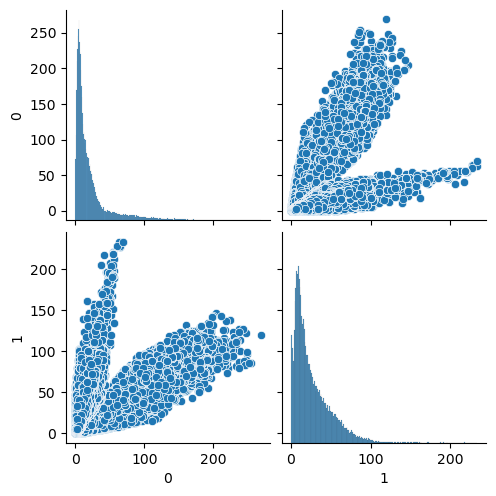

In [60]:
sns.pairplot(pd.DataFrame(l))

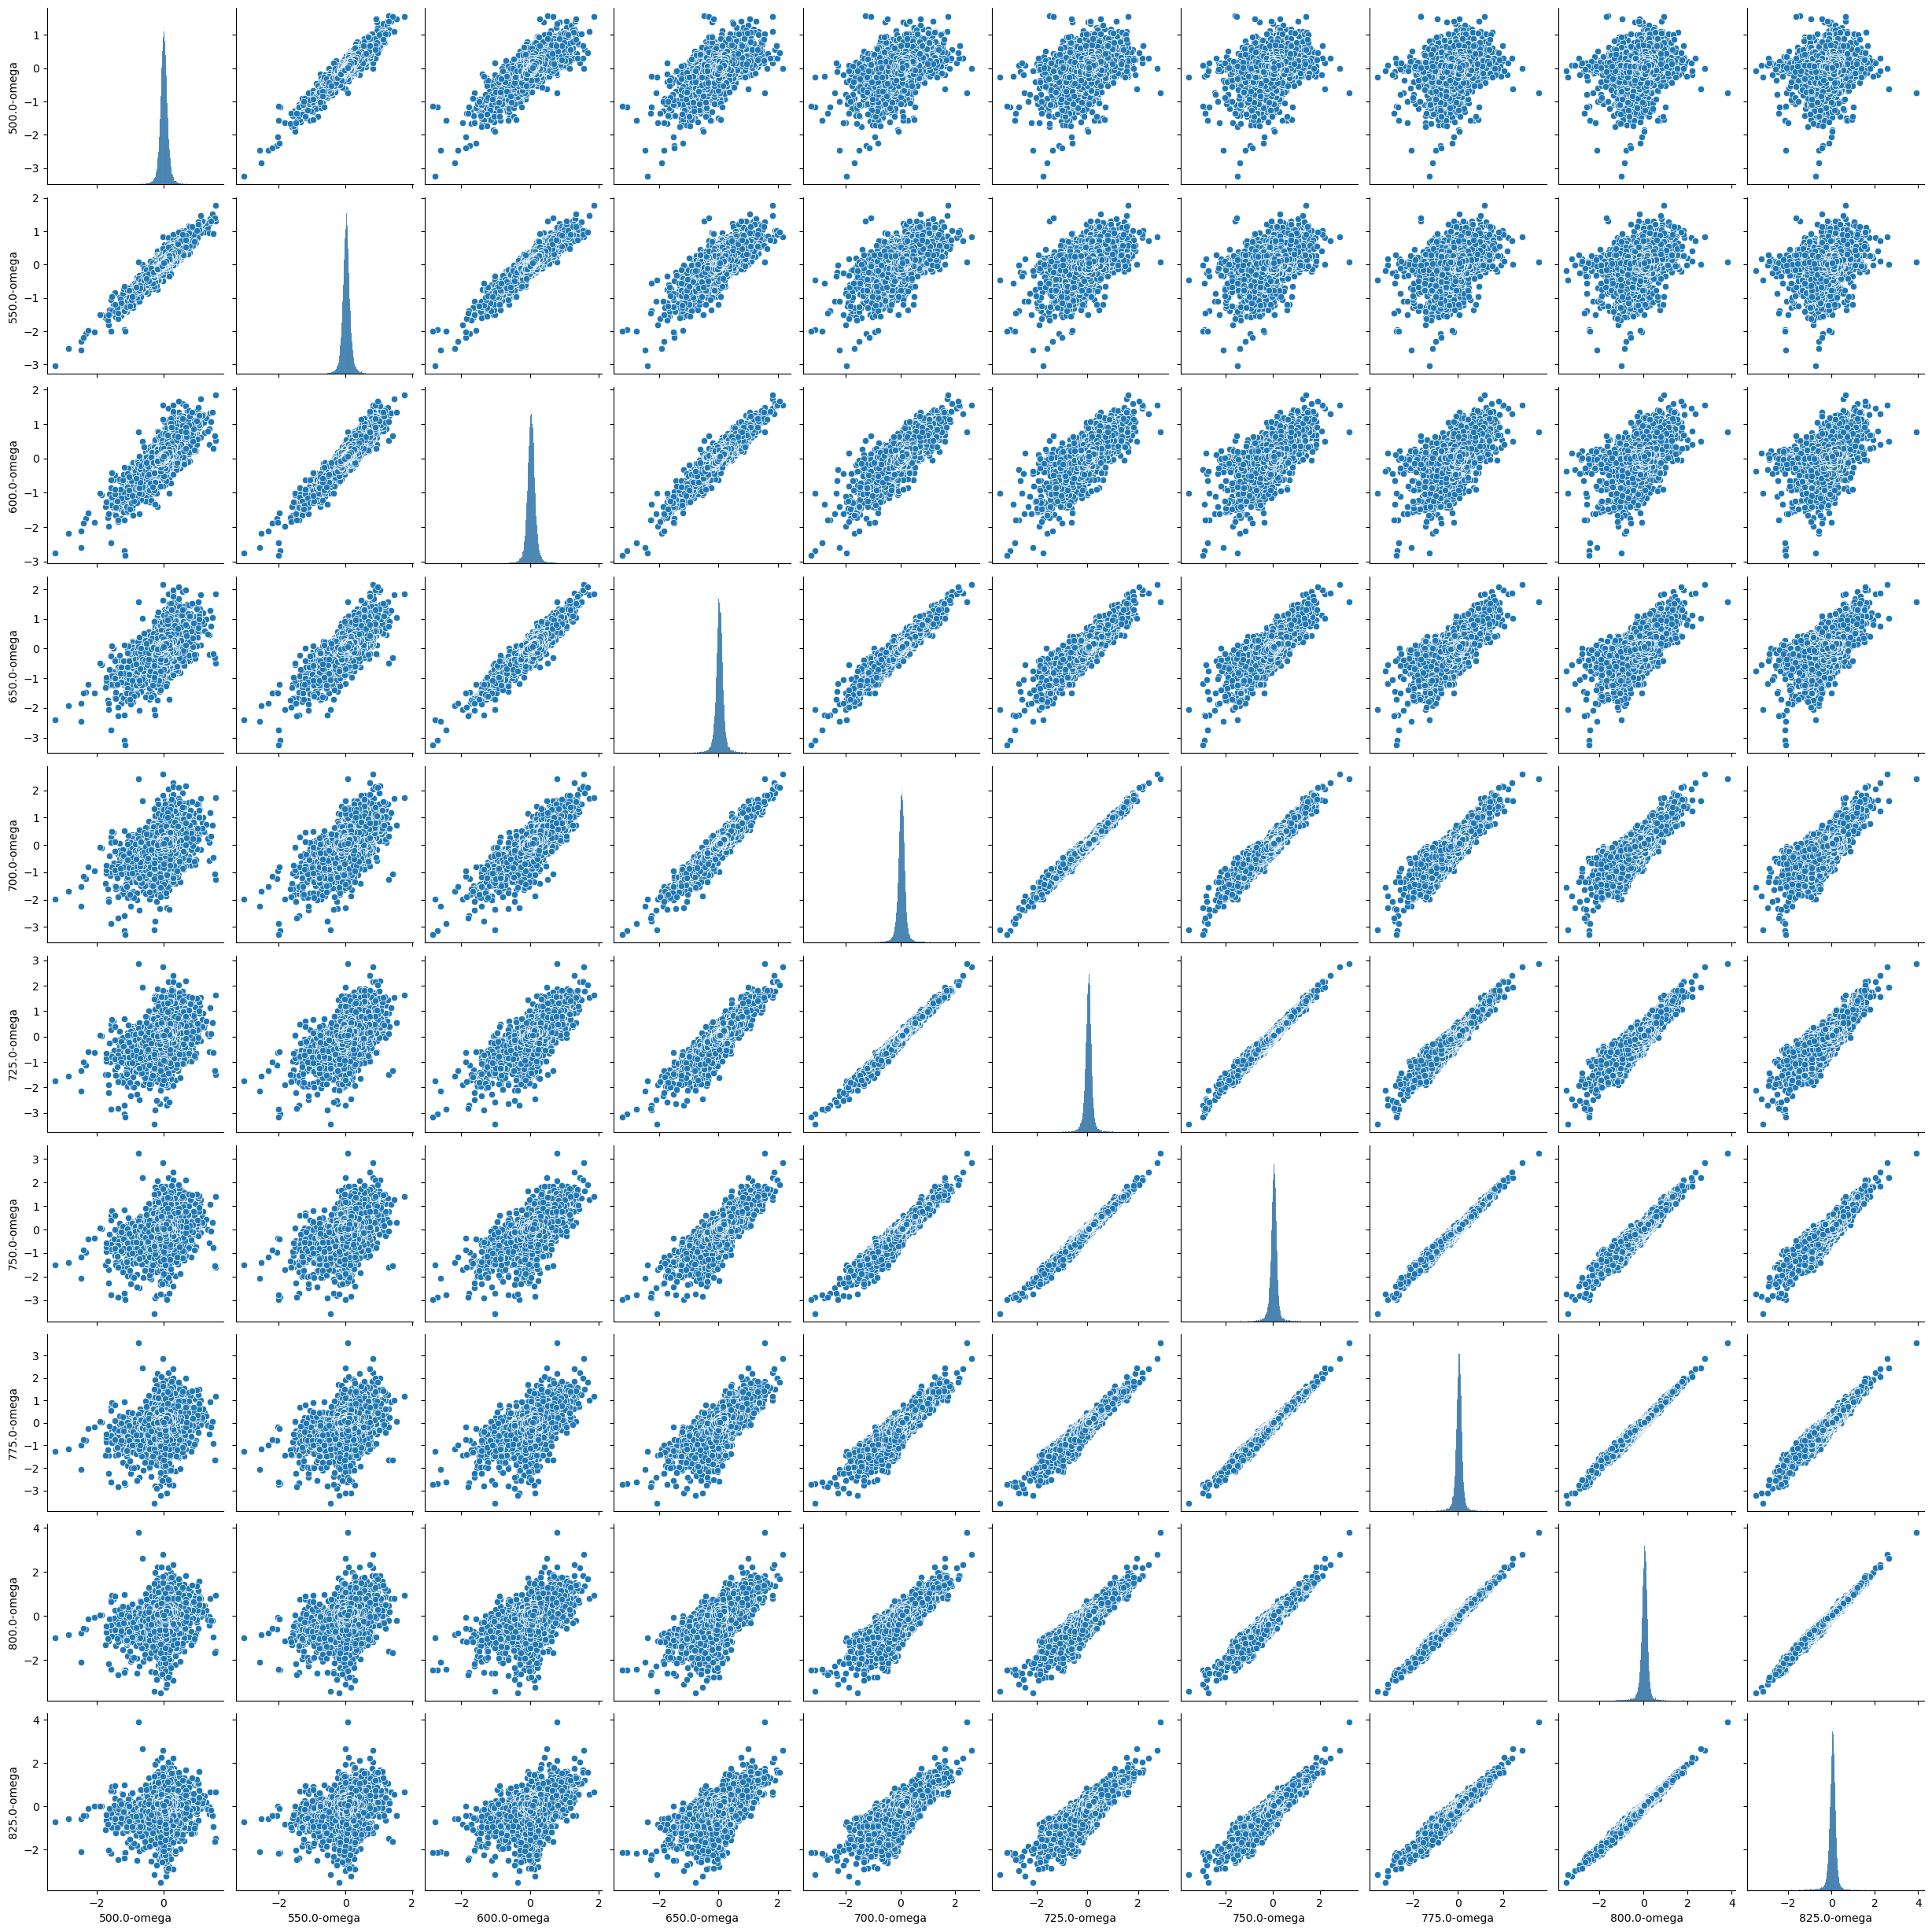

In [35]:
sns.pairplot(data.iloc[:,70:80])